In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
from ipywidgets import *
# from scipy.optimize import minimize

In [2]:
%matplotlib inline

In [3]:
PATH_TO_IMAGE =  '../data_store/2022-10-10_1433_testrecon/2022-10-10_1433_testrecon_result.tif'
im = io.imread(PATH_TO_IMAGE)
# (no. of projections, length, width)
print(im.shape)

(400, 365, 273)


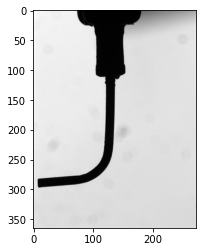

In [4]:
plt.imshow(im[0], cmap='gray')

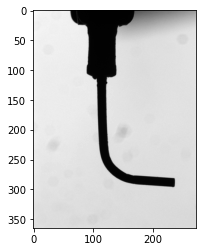

In [5]:
plt.imshow(im[int(len(im)/2)], cmap='gray')

In [6]:
# adapted from: https://stackoverflow.com/a/58142700

def recolour_image(before, bgr=[1.5, 0.75, 1.25]):
    before = cv2.cvtColor(before, cv2.COLOR_GRAY2BGR)
    b, g, r = cv2.split(before)

    np.multiply(b, bgr[0], out=b, casting="unsafe")
    np.multiply(g, bgr[1], out=g, casting="unsafe")
    np.multiply(r, bgr[2], out=r, casting="unsafe")

    after = cv2.merge([b, g, r])
    
    return after

In [7]:
def overlay_images(img1=im[0], img2=im[int(len(im)/2)], translation=-25):
    M = np.float32([
        [1, 0, translation],
        [0, 1, 0]
    ])
    
    img_0 = recolour_image(img1, bgr=[0, 0, 255])
    img_180 = np.fliplr(recolour_image(img2, bgr=[0, 255, 0]))
    img_180_shift = cv2.warpAffine(img_180, M, (img_180.shape[1], img_180.shape[0]))
    blended = cv2.addWeighted(img_0, 0.5, img_180_shift, 0.5, 0.0)
    blended = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
    
    return blended

In [21]:
blended = overlay_images(translation = 0)

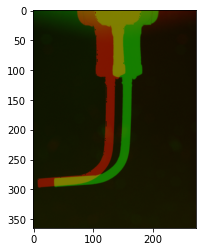

In [22]:
plt.imshow(blended)

In [10]:
# %matplotlib widget

In [11]:
# # NON-INTERACTIVE ANIMATION

# fig = plt.figure()

# translation = -50

# anim_img = plt.imshow(overlay_images(translation=translation), animated=True)

# def updatefig(*args):
#     global translation
#     translation += 1
#     anim_img.set_array(overlay_images(translation=translation))
#     return anim_img,

# ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
# plt.show()

In [12]:
# # INTERACTIVE VERSION

# fig = plt.figure()

# translation = -50

# anim_img = plt.imshow(overlay_images(translation=translation), animated=True)

# def updatefig(translation=-50):
#     anim_img.set_array(overlay_images(translation=translation))
#     fig.canvas.draw_idle()

# interact(updatefig);
# plt.show()

In [13]:
# SUBTRACTION - minimise difference

def subtract_images(img1=im[0], img2=im[int(len(im)/2)], translation=-25):
    M = np.float32([
        [1, 0, translation],
        [0, 1, 0]
    ])
    
    img2 = np.fliplr(img2)
    img_180_shift = cv2.warpAffine(img2, M, (img2.shape[1], img2.shape[0]))
    subtracted = cv2.subtract(img1, img_180_shift)
    
    return subtracted

In [14]:
# # INTERACTIVE VERSION
# # only one widget seems to work at a time, so comment the other one out

# fig = plt.figure()

# translation = -50

# anim_img = plt.imshow(subtract_images(translation=translation), animated=True)

# def updatefig(translation=-50):
#     anim_img.set_array(subtract_images(translation=translation))
#     fig.canvas.draw_idle()
#     x = subtract_images(translation=translation)
#     width = np.shape(x)[1]
#     print('\r', 'Intensity in middle portion:', np.concatenate(x[:,width//4:width*3//4]).sum(), end='')
    
# interact(updatefig);

In [15]:
def misalignment(offset):
    x = subtract_images(translation=offset)
    width = np.shape(x)[1]
    intensity = np.concatenate(x[:,width//4:width*3//4]).sum()
    return intensity

In [16]:
# offsets = []
# misalignments = []

# for i in np.arange(-60, 40):
#     offsets.append(i)
#     misalignments.append(misalignment(i))

# # tidier:
offsets = np.arange(-60, 40)
misalignments = [misalignment(i) for i in offsets]

In [17]:
# %matplotlib inline

In [18]:
# # checking that we do actually have a sensible minimum - we do!
# # (note doing a normal plot interferes with the interactive plots above)
# plt.xlabel('offset')
# plt.ylabel('misalignment (intensity)')
# plt.plot(offsets, misalignments)

In [19]:
# minimize(misalignment, 20)

# # can't get scipy optimisation to work, but doesn't matter
# # we can just scan through all possible offsets and get the min
# # since it must be an integer anyway

In [28]:
stack = np.column_stack((offsets, misalignments))
optimal = stack[np.argmin(stack[:, 1]), 0]
print(f'Optimal offset: {optimal}')

Optimal offset: -28.0


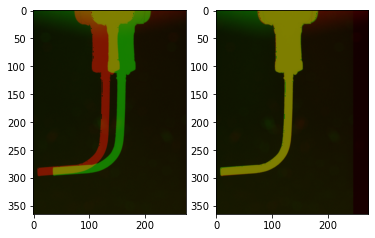

In [30]:
f, axes = plt.subplots(1,2)
axes[0].imshow(overlay_images(translation = 0))
axes[1].imshow(overlay_images(translation = optimal))